<div style="text-align: center">
    <img src="../figures/JuliaEO2024_banner.png" alt="Descriptive Image Text" style="border:1px solid black"/>
</div>



The objectives of this workshop are the following:


- **Understand SAR Imagery**: Gain an understanding of SAR imagery, its properties, and why it's advantageous for maritime surveillance.
- **Data Handling**: Learn how to acquire and prepare SAR data from the Sentinel-1 satellite.
- **Apply Machine Learning**: Explore machine learning techniques, from basic classification to object detection models.
- **Real-World Application**: Gain practical skills in applying these models to real-world SAR data for effective maritime surveillance.



____________________



## Notebooks

- 1: [Sentinel-1 data acquisition](1_Data_acqusition.ipynb)
- 2: [Ship binary classification](2_Ship_binary_classification.ipynb)
- 3: [Two stage ship detection](3_two_stage_ship_detector.ipynb)
- 4: [One stage ship detection](4_One_stage_ship_detector.ipynb)

<div style="text-align: center">
    <img src="../figures/overview_notebooks.png" alt="Descriptive Image Text" width="800" />
</div>



# One stage object detector
 <a class="anchor" id="toc"></a>
 
-  [Objectives](#Objectives)
-  [One stage ship detector](#one_stage_object)
-  [Include modules](#init)
-  [Data](#data)
-  [Transformations](#Transformations)
-  [Inferrence](#inferrence)


## Objectives
 <a class="anchor" id="Objectives"></a>
Back to [Table of Content](#toc)



The objective of this notebook is the following:
1. Detect ship in a new Sentinel-1 image using a one-stage ship detector.


## One stage ship detector
 <a class="anchor" id="one_stage_object"></a>
Back to [Table of Content](#toc)



One-stage object detectors provide a swift and efficient approach for object detection, markedly different from traditional convolutional neural network (CNN) methods. These detectors are designed to perform both object localization and classification in a single, unified step, which is particularly advantageous for real-time applications.



- **Unified Detection Framework**: Utilizes a singular neural network that directly predicts bounding boxes and class probabilities from full images in a single analysis, greatly accelerating the detection process.
- **Grid-based Detection**: The image is dissected into a grid, with each cell tasked with detecting objects within its area.
- **Bounding Box Prediction**: Each grid cell predicts multiple bounding boxes, each accompanied by a confidence score that indicates the probability of an object's presence, along with its class probabilities.



Tailoring this architecture for maritime surveillance allows for the specific identification of maritime entities, such as ships.


1. **Dataset Preparation**: Assemble a dataset of maritime images, with each significant object (like ships) annotated with a bounding box and class label.
2. **Simultaneous Feature Extraction and Prediction**: The model processes the entire image in one go, extracting features while predicting bounding boxes and class probabilities for each grid cell.
3. **Post-processing**: Apply advanced techniques like non-maximum suppression to refine bounding box predictions, ensuring precise and distinct object detection.

**Advantages for Maritime Surveillance** 

- **Real-Time Processing**: The speed of this method is vital in the dynamic maritime environment.
- **Enhanced Detection Accuracy**: These models are adept at detecting a variety of objects, including small or partially obscured maritime items.
- **Flexibility and Adaptability**: With the ability to detect a wide range of objects under different conditions, this method is highly adaptable for various maritime surveillance needs.

Implementing a one-stage detector in maritime surveillance significantly enhances monitoring system capabilities, offering rapid, accurate, and efficient real-time object detection.


| Aspect | One-Stage Ship Detector | Two-Stage Ship Detector (CA-CFAR + Binary Classifier) |
| ------ | ----------------------- | ---------------------------------------------------- |
| **Speed and Efficiency** | High efficiency and speed, suitable for real-time applications. | Generally slower due to the two-stage process, particularly in the CA-CFAR stage. |
| **Detection Accuracy** | High accuracy, especially in clear conditions; may struggle with small or overlapping objects. | High accuracy in detection; CA-CFAR excels in distinguishing ships from background noise. |
| **Complexity** | Lower complexity with a single unified model. | Higher complexity due to the combination of two distinct stages. Very difficult to optimize |
| **Real-Time Capability** | Excellent for real-time detection due to processing speed. | Limited in real-time applications due to the sequential processing stages. |
| **Flexibility** | Highly adaptable to various object sizes and conditions. | Adaptability can be limited; effectiveness of object detection depends on the accuracy of the CA-CFAR stage. Effectives of the classifier is HIGHLY dependant on the data and model (especially using softmax loss function). I.e., if the classifier sees a new type of object, it might say there is a 100 % it is a ship, while infact it is not. |
| **Resource Intensity** | Less resource-intensive as it involves a single neural network. | More resource-intensive, requiring computational power for both detection stages. |
| **Robustness to Noise** | Robust depending on training method. | The CA-CFAR stage is specifically designed to handle high clutter and noise levels. |
| **Ease of Training** | Complex to develop the model. But simplified training process with a single network. | Needing fine-tuning for both stages. |


** One-stage ship detector steps**:

First, The image is divided into a grid of cells, with each cell tasked with detecting objects within its area.

<div style="text-align: center">
    <img src="../figures/notebooks/onestage_1.png" alt="Not a ship" style="width: 500px; border: 1px solid black; display: inline-block;"/>
    <figcaption>Iceye image from the port of Rotterdam. The image is divided into a grid of cells. </figcaption>

</div>


Each cell in the grid predicts bounding boxes, each accompanied by a confidence score that indicates the probability of an object's presence, along with its class probabilities.  (here, red is ship and yellow is crane)
<div style="text-align: center">
    <img src="../figures/notebooks/onestage_2.png" alt="Ship" style="width: 500px; border: 1px solid black; display: inline-block;"/>
    <figcaption>In each cell, different objects will be detected, here illustrated with different colours with  red colours corrsponding to ships. </figcaption>


</div>

For each predicted object, we can illustrate its bounding box (from its estimated center coordinates and width/height). The same object can thus have several bounding boxes. 

<div style="text-align: center">
    <img src="../figures/notebooks/onestage_3.png" alt="Not a ship" style="width: 500px; border: 1px solid black; display: inline-block;"/>
    <figcaption>Each detected object has a corrsponding estimated bounding box. </figcaption>
</div>

We can then remove the "extra" bounding boxes for each object, resulting in one bounding box for each object.

<div style="text-align: center">
    <img src="../figures/notebooks/onestage_4.png" alt="Ship" style="width: 500px; border: 1px solid black; display: inline-block;"/>
</div>


The model processes the entire image in one go, extracting features while predicting bounding boxes and class probabilities for each grid cell. Finally, advanced techniques like non-maximum suppression are applied to refine bounding box predictions, ensuring precise and distinct object detection.

<div style="text-align: center">
    <img src="../figures/notebooks/Onestage_part0.png" alt="Ship" style="width: 1300px; display: inline-block;"/>
</div>


## Init <a class="anchor" id="init">​</a>


Back to [Table of Content](#toc)

In [1]:
using Pkg, Makie, GLMakie, Plots
GLMakie.activate!(inline=true)

include("../src/test_name.jl")
using .Test_name

## Data 
<a class="anchor" id="data">​</a>

Back to [Table of Content](#toc)

Using the methodology described in [Sentinel-1 data acquisition](1_Data_acqusition.ipynb), we downloaded a Sentinel-1 Image. 

We now want to detect ships in the same image. For this workshop, a template image is provided in the Datafolder


<div style="text-align: center">
    <img src="../figures/notebooks/Onestage_part1.png" alt="Ship" style="width: 1300px; display: inline-block;"/>
</div>


The Sentinel-1 image can be loaded using the Sentinel1GRD function

```julia
test_img = Test_name.Sensors.Sentinel1.Sentinel1GRD(safe_path);
```

<div class="alert alert-block alert-info"> <b>Task: </b>

1. Load the Sentinel-1 IW GRD image from Notebook 1 : S1A_IW_GRDH_1SDV_20220612T173329_20220612T173354_043633_05359A_EA25

2. Confirm the image is loaded correctly by plotting the image and the metadata, e.g., by checking the image mode and elevation angle
    - println(test_img.metadata.header.swath)
    - println("Elevation angles: $(test_img.metadata.geolocation.elevation_angle[1:10])")


### Loading the image:




In [2]:
safe_folder = "../data/S1A_IW_GRDH_1SDV_20220612T173329_20220612T173354_043633_05359A_EA25.SAFE";
test_img = Test_name.Sensors.Sentinel1.Sentinel1GRD(safe_folder);

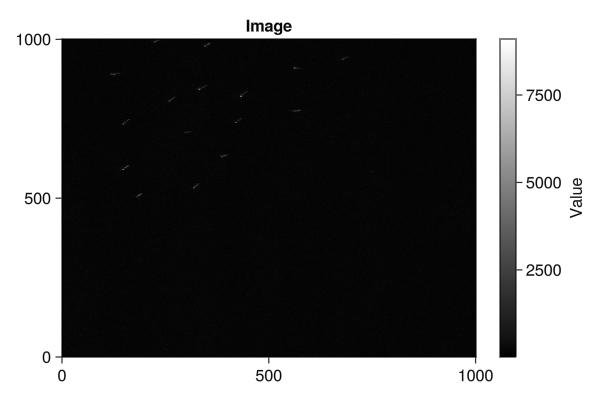

GLMakie.Screen(...)

In [3]:

# Create a figure with an image plot and a colorbar
fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1], title = "Image")
im = image!(ax, test_img.data[1][4000:5000,4000:5000], colormap = :greys, colorrange = (minimum(test_img.data[1][4000:5000,4000:5000]), maximum(test_img.data[1][4000:5000,4000:5000])))
Colorbar(fig[1, 2], im, label = "Value", vertical = true)
display(fig)

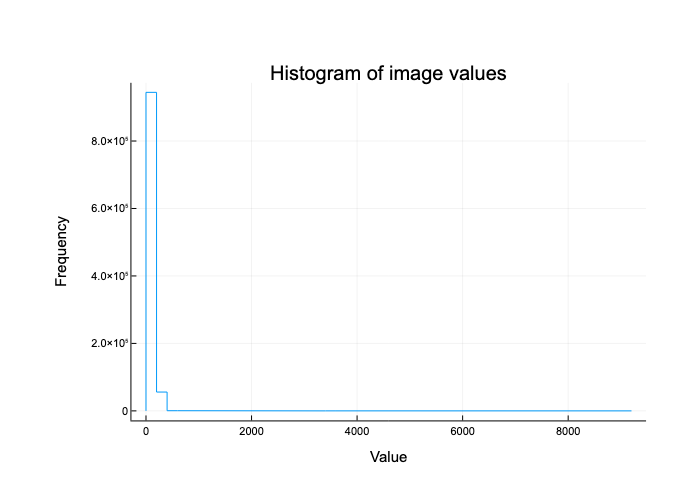

In [4]:
flat_matrix = vec(test_img.data[1][4000:5000,4000:5000])
histogram(flat_matrix, bins=50, xlabel="Value", ylabel="Frequency", title="Histogram of image values", legend=false)

In [5]:
println(test_img.metadata.header.swath)

Main.Test_name.Sensors.Sentinel1.IW()


### Transformations
<a class="anchor" id="Transformations">​</a>

Different types of transformations can be applied to the training images for a deep learning model. After a model has been trained, it is important to apply the same transformation to the images that we want to use for inferrence. 

Using the TransformCompose, we can apply different transformations to our image

In [6]:
s1_transform = Test_name.Ship_detector.Transformation.TransformCompose([
    Test_name.Ship_detector.Transformation.absolute,
    x -> Test_name.Ship_detector.Transformation.clip_to_valid_range(x, amin=1, amax=65535),
    Test_name.Ship_detector.Transformation.to_db,
    x -> Test_name.Ship_detector.Transformation.min_max_scale(x, data_max=48.17, data_min=0, to_max=1, to_min=0),
    x -> Test_name.Ship_detector.Transformation.two_to_three_channel(x, [1, 2, 2]),
    Test_name.Ship_detector.Transformation.to_float32,
]);


And now applying the transformation to the image

In [7]:
test_img2 = s1_transform(test_img.data);

<div class="alert alert-block alert-info"> <b>Task: </b>

1. Confirm that the transformations have been applied correctly by plotting the image again.

### Plots

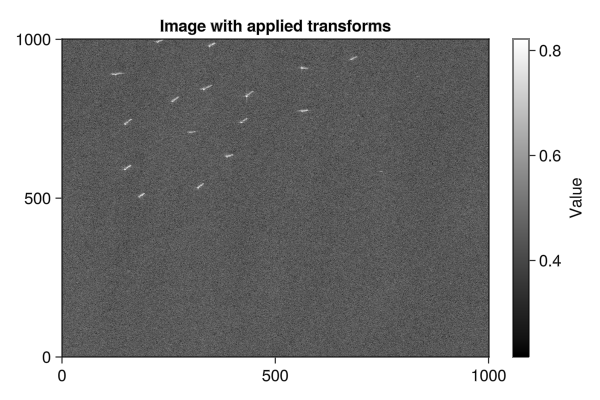

GLMakie.Screen(...)

In [8]:

fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1], title = "Image with applied transforms")
im = image!(ax, test_img2[1,4000:5000,4000:5000], colormap = :greys, colorrange = (minimum(test_img2[1,4000:5000,4000:5000]), maximum(test_img2[1,4000:5000,4000:5000])))
Colorbar(fig[1, 2], im, label = "Value", vertical = true)
display(fig)

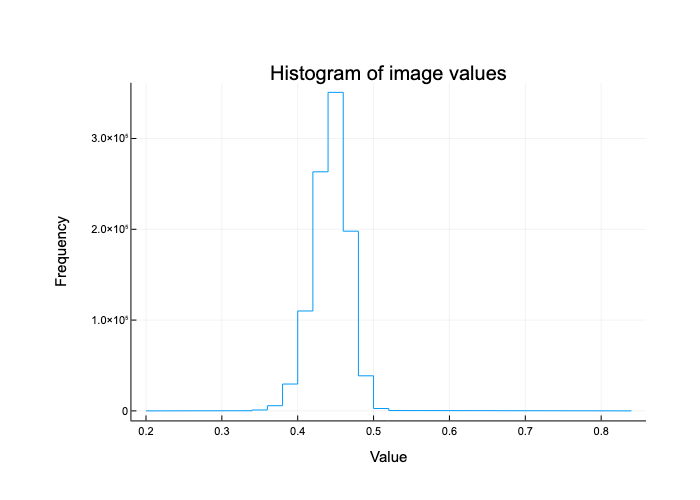

In [9]:
flat_matrix = vec(test_img2[1,4000:5000,4000:5000])
histogram(flat_matrix, bins=50, xlabel="Value", ylabel="Frequency", title="Histogram of image values", legend=false)

## Inferrence  <a class="anchor" id="inferrence">​</a>

Back to [Table of Content](#toc)

A very simple one-stage ship detector has been trained on a small dataset. The model is available in the data/models folder. Ofte, models are as large as 500 mb+. The one used in this workshop is  7.8 mb. While its performance is not as good as the state-of-the-art models, it is still able to detect ships in the image very fast.


<div style="text-align: center">
    <img src="../figures/notebooks/Onestage_part2.png" alt="Ship" style="width: 1300px; display: inline-block;"/>
</div>




In [10]:
model_path = "../data/Model/one_stage_model.onnx";

In [11]:
model =  Test_name.Ship_detector.Model.OneStageDetector.load_model(model_path = model_path)

InferenceSession
    input_names:        ["images"]
    output_names:       ["output0"]
    execution_provider: :cpu


You can use https://netron.app/ to illustrate the model if you want to look into the layers.

Here, we will focus on a small subset of the image containing ships

In [12]:
input = test_img2[:,4000:5000,4000:5000];

<div style="text-align: center">
    <img src="../figures/notebooks/Onestage_part3.png" alt="Ship" style="width: 1300px; display: inline-block;"/>
</div>


In [13]:
results = Test_name.Ship_detector.Model.OneStageDetector.process_image_for_onnx(model, input);

<div style="text-align: center">
    <img src="../figures/notebooks/Onestage_part4.png" alt="Ship" style="width: 1300px; display: inline-block;"/>
</div>


<div class="alert alert-block alert-info"> <b>Task: </b>

1. Display the detected ships

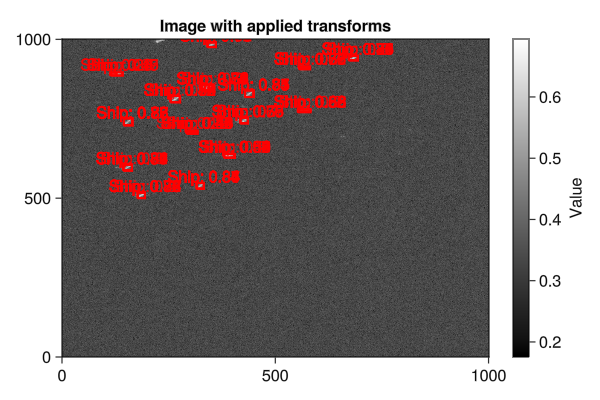

GLMakie.Screen(...)

In [15]:
Test_name.Visualize.plot_image_with_boxes(image_matrix = input[2,:,:], bbox_dict = results, confidence_threshold = 0.20)



<div class="alert alert-block alert-info"> <b>Task: </b>

We have now detected ship in the image. However, we are not done yet. We should implement a Non max supression, i.e., to supress the "double" detections.


1. Implement an algorithm to supress the extra detections. 

2. Implement a method to handle batches of images. 

3. combine the results. 


### 